In [6]:
#import and lode modules
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')


In [8]:
Root="/content/drive/MyDrive/NewDataset3/Brain Tumour1"
number_of_images={}
for dir in os.listdir(Root):
  number_of_images[dir]=len(os.listdir(os.path.join(Root,dir)))


In [9]:
number_of_images.items()

dict_items([('Non tumour', 2075), ('Tumour', 1687)])

In [10]:
#Split the data -> 70% for train, 15% for validation, 15% for testing

def dataFolder(p,split):

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(Root):
      os.makedirs("./"+p+"/"+dir)

      for img in np.random.choice(a=os.listdir(os.path.join(Root,dir)),
                                  size=(math.floor(split*number_of_images[dir])-5),
                                  replace=False):

        O=os.path.join(Root,dir,img)
        D=os.path.join("./"+p,dir)
        shutil.copy(O,D)
        #os.remove(O)

  else:
    print( f"{p}folder exists")


In [11]:
dataFolder("train",0.7)

In [12]:
dataFolder("validation",0.15)

In [13]:
dataFolder("test",0.15)

In [14]:
#Model build

from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras


In [15]:
import keras
print(keras.__version__)


2.12.0


In [16]:

#CNN model

from keras.models import Sequential  # Make sure to import Sequential with an uppercase "S"
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(GlobalAvgPool2D())  # Add Global Average Pooling layer

model.add(Dropout(rate=0.25))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [17]:
model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [18]:
#use data generator

def preImage1(path):
  """
  input:path
  output:pre proccessed images
  """
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True)  #data augmentation

  image=image_data.flow_from_directory(directory=path,target_size=(244,244),batch_size=32,class_mode='binary')

  return image


In [19]:
from tensorflow.python.util.compat import path_to_str
path="/content/train"

train_data=preImage1(path)

Found 2622 images belonging to 2 classes.


In [20]:
#use data generator

def preImage2(path):
  """
  input:path
  output:pre proccessed images
  """
  image_data=ImageDataGenerator(rescale=1/255)#no data augmentation in testing

  image=image_data.flow_from_directory(directory=path,target_size=(244,244),batch_size=32,class_mode='binary')

  return image

In [21]:
path="/content/test"

test_data=preImage2(path)

Found 554 images belonging to 2 classes.


In [22]:
path="/content/validation"

val_data=preImage2(path)

Found 554 images belonging to 2 classes.


In [23]:
#early stopping and model check point

from keras.callbacks import ModelCheckpoint,EarlyStopping

#early stopping

es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=12,verbose=1,mode='auto')

#model checkpoint


mc=ModelCheckpoint(monitor="val_accuracy",filepath="./bestmodel.h5",verbose=1,save_best=True,mode='auto')

cd=[es,mc]

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
#Model training

hs=model.fit_generator(generator=train_data,
                       steps_per_epoch=8,
                       epochs=30,
                       verbose=1,
                       validation_data=val_data,
                       validation_steps=16,
                       callbacks=cd)


<ipython-input-25-c6eb9cb9397b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hs=model.fit_generator(generator=train_data,


Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5273
Epoch 1: saving model to ./bestmodel.h5
8/8 [==============================] - 20s 609ms/step - loss: 0.6938 - accuracy: 0.5273 - val_loss: 0.6865 - val_accuracy: 0.5625
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5625
Epoch 2: saving model to ./bestmodel.h5
8/8 [==============================] - 4s 548ms/step - loss: 0.6869 - accuracy: 0.5625 - val_loss: 0.6854 - val_accuracy: 0.5488
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5312
Epoch 3: saving model to ./bestmodel.h5
8/8 [==============================] - 6s 837ms/step - loss: 0.6902 - accuracy: 0.5312 - val_loss: 0.6833 - val_accuracy: 0.5508
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5664
Epoch 4: saving model to ./bestmodel.h5
8/8 [==============================] - 5s 583ms/step - loss: 0.6805 - accuracy: 0.56

In [26]:
#Model graphical interpretation

h=hs.history
h.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

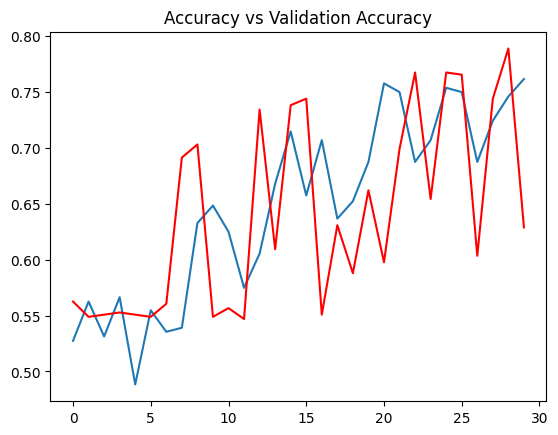

In [27]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])

plt.plot(h['val_accuracy'],c='red')

plt.title('Accuracy vs Validation Accuracy')
plt.show()

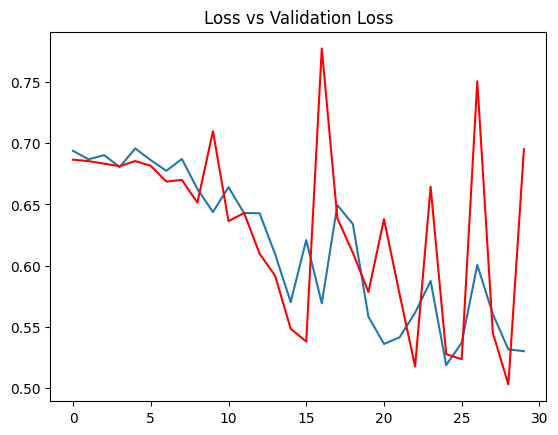

In [28]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])

plt.plot(h['val_loss'],c='red')

plt.title('Loss vs Validation Loss')
plt.show()

In [29]:
#Model accuracy

from keras.models import load_model
model=load_model("/content/bestmodel.h5")

In [30]:
model.save('/content/model.keras')

In [31]:
model = keras.models.load_model('/content/model.keras')

In [32]:
acc=model.evaluate(test_data)[1]

print(f"Accuracy of the model is {acc*100}% ")

18/18 [==============================] - 2s 83ms/step - loss: 0.6935 - accuracy: 0.6516
Accuracy of the model is 65.16245603561401% 


In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [34]:
import tensorflow as tf
print(tf.__version__)

2.12.0


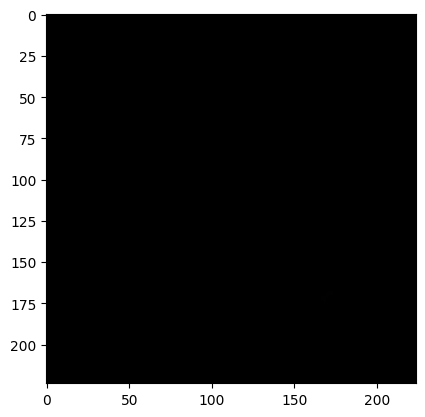

1/1 [==============================] - 0s 367ms/step
MRI is Having a Tumour


In [37]:
path="/content/drive/MyDrive/BrainSpot/Brain Tumour 1/Testing/no_tumor/image(102).jpg"

img=load_img(path,target_size=(224,224))

input_arr=img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

# Expand dimensions to match the input shape of your model
input_arr = np.expand_dims(input_arr, axis=0)

# Make predictions
predictions = model.predict(input_arr)

# Assuming class 0 corresponds to "Tumour" and class 1 corresponds to "No Tumour"
if predictions[0][0] >= 0.5:
    print("MRI is Not having a tumour")
else:
    print("MRI is Having a Tumour")


In [38]:
train_data.class_indices
{'Non tumour':0,"Tumour":1}

{'Non tumour': 0, 'Tumour': 1}

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model_path = "/content/drive/MyDrive/Project1/bestmodel(1).h5"  # Replace with the path to your model
model = load_model(model_path)

# Load the test data using an ImageDataGenerator
def preImage2(path):
    """
    input:path
    output:preprocessed images
    """
    image_data = ImageDataGenerator(rescale=1/255)  # No data augmentation in testing

    image = image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='binary')

    return image

path = "/content/drive/MyDrive/NewDataset4/Brain Tumour1"
test_data = preImage2(path)

# Make predictions on the test data
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)


Found 3792 images belonging to 2 classes.
119/119 [==============================] - 999s 8s/step
Accuracy: 0.5160864978902954
Precision: 0.43018867924528303
Recall: 0.2703023117960877
F1-Score: 0.33199854386603567
Confusion Matrix:
 [[1501  604]
 [1231  456]]
Classification Report:
               precision    recall  f1-score   support

  Non tumour       0.55      0.71      0.62      2105
      Tumour       0.43      0.27      0.33      1687

    accuracy                           0.52      3792
   macro avg       0.49      0.49      0.48      3792
weighted avg       0.50      0.52      0.49      3792

